# Detección de caras mediante Machine Learning

Previamente a utilizar esta técnica para reconocer los fitolitos en nuestras imagenes, utilizaremos esta técnica para reconocer caras en diversas imagenes. Si el reconocimiento de caras es efectivo, más tarde aplicaremos esta técnica para reconocer fitolitos.

Antes que nada deberemos extraer las caracteristicas de los datos, las cuales trataremos de obtener mediante la técnica HoG ( Histogram of Oriented Gradients), la cual transforma los pixeles en un vector que contiene información mucho más significativa.
Y finalmente, utilizaremos una SVM para construir nuestro reconocedor de caras.

Este *notebook* ha sido creado y está basado partiendo del *notebook* "Application: A Face Detection Pipeline" del libro *[Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do)* de *Jake VanderPlas* cuyo contenido se encuentra en *[GitHub](https://github.com/jakevdp/PythonDataScienceHandbook)*

In [1]:
#Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Histogram of Oriented Gradients (HoG)

Como veniamos contando, HoG es una técnica para la extracción de características, desarrollada en el contexto del procesado de imagenes, que involucra los siguientes pasos:

1. Pre-normalizado de las imagenes. Supone una mayor dependencía de las características que varían segun la iluminación.
2. Aplicar a la imagen dos filtros sensibles al brillo tanto horizontal como vertical. Lo cual nos aporta información sobre bordes, contornos y texturas.
3. Subdividir la imagen en celdas de un tamaño concreto y calcular el histograma del gradiente para cada celda.
4. Normalizar los histogramas, previamente calculados, mediante la comparación con sus vecinos. Eliminando así el efecto de la iluminación en la imagen.
5. Construir un vector de caracteristicas unidimensional de la información de cada celda.

## ¿Más explicaciones de HoG?

# Detector de caras

Utilizando, como ya indicabamos, una SVM junto con nuestro extractor de características HoG construiremos un detector de caras. Para la construcción de este detector se deberán de seguir los siguiente pasos:

1. Crear un conjunto de entrenamiento de imagenes de caras que supongan positivos.
2. Crear un conjunto de entrenamiento de imagenes de no-caras que supongan falsos-positivos.
3. Extraer las características de HoG del conjunto de entrenamiento.
4. Entrenar el clasificador SVM.

Una vez realizados dichos pasos, podríamos enviar nuevas imagenes al clasificador para que tratase de reconocer nuevas caras. Para ello seguiría los dos siguiente pasos:

1. Pasa una ventana por toda la imagen, comprobando si la ventana contiene una cara.
2. Si existe solapamiento en la detección de la cara, se deben de combinar dichos solapamientos.

## 1. Crear un conjunto de entrenamiento de imagenes de caras que supongan positivos
Scikit nos proporciona un conjunto de imagenes variadas de caras que nos permitiran obtener un conjunto de entrenamiento de positivos para nuestro objetivo. Más de 13000 caras para ser concretos.



In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

## 2. Crear un conjunto de entrenamiento de imagenes de no-caras que supongan falsos-positivos
Una vez obtenido nuestro conjunto de positivos, necesitamos obtener un conjunto de imagenes que no tengan caras. Para ello, la técnica que se utiliza en el *notebook* en el que me estoy basando es obtener diversas imagenes de las cuales se obtiene subimagenes o miniaturas,*thumbnails* en ingles, con diversas escalas.

In [3]:
from skimage import feature, color, data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [4]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

## 3. Extraer las características de HoG del conjunto de entrenamiento
Este tercer paso resulta de especial interes, puesto que vamos a obtener las características de HoG sobre las que previamente hemos hablado.

In [5]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

## 4. Entrenar el clasificador SVM

# A COMPLETAR EXPLICACIONES

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

D:\Program Files\Anaconda3\envs\opencv\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([ 0.94108667,  0.87495663,  0.93976823])

In [7]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

grid.best_params_

model = grid.best_estimator_
model.fit(X_train, y_train)

D:\Program Files\Anaconda3\envs\opencv\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


LinearSVC(C=4.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# Probando con nuevas caras

Una vez entrenado nuestro clasificador, vamos a probar con una nueva imagen. Como ya explicabamos en la introducción, cuando le enviamos nuevas imagenes a nuestro clasificador este deberá de realizar dos pasos:

1. Pasa una ventana por toda la imagen, comprobando si la ventana contiene una cara.
2. Si existe solapamiento en la detección de la cara, se deben de combinar dichos solapamientos.

La nueva imagen que le vamos a enviar a nuestro clasificador contendrá un único ejemplo.

## Creamos la función que recorre con una ventana la imagen

In [8]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

## Obtenemos la imagen y la convertimos a escala de grises

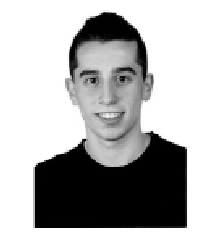

In [9]:
from skimage.exposure import rescale_intensity
from skimage import io
from skimage.transform import rescale

img = io.imread("..\\rsc\\my_face.jpg")

# Convertimos imagen a escala de grises
from skimage.color import rgb2gray
img = rgb2gray(img)
img = rescale(img, 0.3)

# Mostramos la imagen resultante
plt.imshow(img, cmap='gray')
plt.axis('off');

In [10]:
indices, patches = zip(*sliding_window(img))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(666, 1215)

In [11]:
labels = model.predict(patches_hog)
labels.sum()

51.0

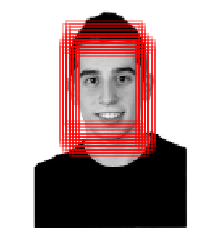

In [12]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
boxes = list()
for i, j in indices[labels == 1]:
    boxes.append((i,j,i+Ni,j+Nj))
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))
boxes = np.array(boxes)

Como podemos observar nuestro clasificador reconoce perfectamente una cara. Ahora vamos a probar con una imagen en la que aparezcan varias caras.

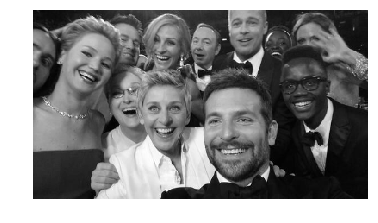

In [13]:
img = io.imread("..\\rsc\\faces_test.jpg")

# Convertimos imagen a escala de grises
from skimage.color import rgb2gray
img = rgb2gray(img)
img = rescale(img, 0.65)

# Mostramos la imagen resultante
plt.imshow(img, cmap='gray')
plt.axis('off');

In [14]:
indices, patches = zip(*sliding_window(img))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(12956, 1215)

In [15]:
labels = model.predict(patches_hog)
labels.sum()

400.0

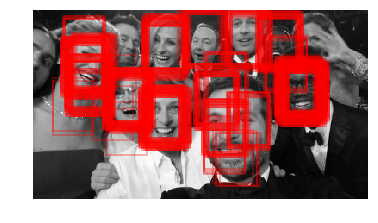

In [16]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

boxes = list()
for i, j in indices[labels == 1]:
    boxes.append((j,i,j+Nj,i+Ni))
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))
boxes = np.array(boxes)

A primera impresión parece que el clasificador es bastante efectivo. En el caso de esta última imagen ha sido capaz de reconocer la mayoría de las caras, aun siendo una imagen compleja para su procesado por el distinto tamaño de las caras y la incompletitud de algunas.

# Non-Maximum Suppresion

Como hemos podido observar nuestro clasificador detecta muchas más caras de las que realmente hay. Debido a la razón de que normalmente los clasificadores detectan multiples ventanas en torno al objeto a detectar, en este caso caras. Esta problemática viene a ser solucionada mediante *Non-Maximum Suppresion*

In [ ]:
# import the necessary packages
import numpy as np

# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [ ]:
import cv2

# load the image and clone it
#print "[x] %d initial bounding boxes" % (len(boundingBoxes))
image = img
orig = image.copy()
boundingBoxes = boxes
# loop over the bounding boxes for each image and draw them
for (startX, startY, endX, endY) in boundingBoxes:
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 0, 255), 2)

# perform non-maximum suppression on the bounding boxes
pick = non_max_suppression_fast(boundingBoxes, 0.2)
#print "[x] after applying non-maximum, %d bounding boxes" % (len(pick))

# loop over the picked bounding boxes and draw them
for (startX, startY, endX, endY) in pick:
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# display the images
cv2.imshow("Original", orig)
cv2.imshow("After NMS", image)
cv2.waitKey(0)